Задание:
В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.
Ответьте на 2 вопроса:
Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

In [1]:
# ! pip install numpy pandas scipy statsmodels matplotlib seaborn

You should consider upgrading via the '/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/bin/python -m pip install --upgrade pip' command.


In [4]:
# Библиотеки
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# Настройки отображения графиков
%matplotlib inline
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

In [5]:
# Используем всю выборку

In [14]:
df = pd.read_csv('./ab_test_ensembles.csv')
df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [8]:
# create a df with only registered users
reg_users = df.copy()
reg_users.drop(reg_users[reg_users['user_type'] == "new_user"].index, inplace = True)

In [13]:
reg_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147240 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    147240 non-null  object
 1   timestamp  147240 non-null  object
 2   group      147240 non-null  object
 3   variants   147240 non-null  object
 4   converted  147240 non-null  int64 
 5   location   147240 non-null  object
 6   age_group  147240 non-null  object
 7   user_type  147240 non-null  object
dtypes: int64(1), object(7)
memory usage: 10.1+ MB


In [17]:
# create a df with only new users
new_users = df.copy()
new_users.drop(new_users[new_users['user_type'] == "registered_user"].index, inplace = True)

In [20]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147238 entries, 2 to 294476
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    147238 non-null  object
 1   timestamp  147238 non-null  object
 2   group      147238 non-null  object
 3   variants   147238 non-null  object
 4   converted  147238 non-null  int64 
 5   location   147238 non-null  object
 6   age_group  147238 non-null  object
 7   user_type  147238 non-null  object
dtypes: int64(1), object(7)
memory usage: 10.1+ MB


In [22]:
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [24]:
session_counts = df['user_id'].value_counts(ascending=False)
dublicate_users = session_counts[session_counts > 1].count()

print(f'There are {dublicate_users} users that appear multiple times in our dataset')
# so we dont have to delete any users

There are 0 users that appear multiple times in our dataset


In [46]:
# We will create a function to calculate statistics, as we have to reuse it later
# calculate statistics
def calculate_stats(conversion_rates):
        # Стандартное отклонение для сформированной выборки
        std_proportion = lambda x: np.std(x, ddof=0)
        # Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
        se_proportion = lambda x: stats.sem(x, ddof=0)

        conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
        return conversion_rates
# treatment shows even worse results as control

In [49]:
conversion_rate_whole = df.groupby('group')['converted']
calculate_stats(conversion_rates=conversion_rate_whole)

,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118920,0.323694,0.000843


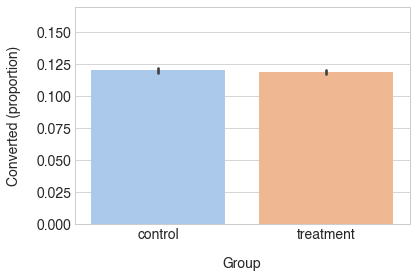

In [32]:
# display conversion rate mean
sns.set_palette("pastel")
sns.barplot(x=df['group'], y=df['converted'])
plt.ylim(0, 0.17);
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [37]:
#We will put our hypothesis test in a function because we have to use it 3 times
#Testing our hypothesis for the whole data set

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
def hypothesis_test (control_results, treatment_results):

        n_con = control_results.count()
        n_treat = treatment_results.count()
        successes = [control_results.sum(), treatment_results.sum()]
        nobs = [n_con, n_treat]

        z_stat, pval = proportions_ztest(successes, nobs=nobs)
        (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

        print(f'Z-statistic: {z_stat:.2f}')
        print(f'p-value: {pval:.3f}')
        print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
        print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

In [38]:
control = df[df['group'] == 'control']['converted']
treatment = df[df['group'] == 'treatment']['converted']
hypothesis_test(control_results= control, treatment_results = treatment)

Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


Так как p-value больше нашей альфы (0.05) нам стоит оставить старую версию сайта

***Теперь подсчитаем статистику только для новых пользователей и проведем тест***

In [51]:
# calculate statistics
conversion_rates_new = new_users.groupby('group')['converted']
calculate_stats(conversion_rates=conversion_rates_new)

,CR mean,CR std,CR se
group,,,
control,0.120746,0.325832,0.001200
treatment,0.117557,0.322082,0.001188


In [52]:
control_new = new_users[new_users['group'] == 'control']['converted']
treatment_new = new_users[new_users['group'] == 'treatment']['converted']
hypothesis_test(control_results= control_new, treatment_results = treatment_new)

Z-statistic: 1.89
p-value: 0.059
CI 95% for control group: [0.118, 0.123]
CI 95% for treatment group: [0.115, 0.120]


Здесь p-value получилось меньше всего, но наша конверсия хуже чем у контрольной группы, поэтому в любом случае нет смысла менять сайт

А теперь для старых пользователей

In [53]:
# calculate statistics
conversion_rates_reg = reg_users.groupby('group')['converted']
calculate_stats(conversion_rates=conversion_rates_reg)

,CR mean,CR std,CR se
group,,,
control,0.120051,0.325021,0.001199
treatment,0.120277,0.325285,0.001197


In [40]:
control_reg = reg_users[reg_users['group'] == 'control']['converted']
treatment_reg = reg_users[reg_users['group'] == 'treatment']['converted']
hypothesis_test(control_results= control_reg, treatment_results = treatment_reg)

Z-statistic: -0.13
p-value: 0.894
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]


Во всех случаях наше p-value больше альфы, поэтому можно оставить старый сайт. И к тому же наш доверительный интервал ни в каком случае не достиг 15%